DATA COLLECTION



In [ ]:
#mounting google drive inorder to
from google.colab import drive
drive.mount('/content/drive')
#importing data from gdrive
import pandas as pd
data = pd.read_csv('/content/drive/MyDrive/RESEARCH_UNDER_JAHANGEER_SIR/movie_metadata.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
print(data.columns)

Index(['color', 'director_name', 'num_critic_for_reviews', 'duration',
       'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name',
       'actor_1_facebook_likes', 'gross', 'genres', 'actor_1_name',
       'movie_title', 'num_voted_users', 'cast_total_facebook_likes',
       'actor_3_name', 'facenumber_in_poster', 'plot_keywords',
       'movie_imdb_link', 'num_user_for_reviews', 'language', 'country',
       'content_rating', 'budget', 'title_year', 'actor_2_facebook_likes',
       'imdb_score', 'aspect_ratio', 'movie_facebook_likes'],
      dtype='object')


DATA CLEANING


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import missingno as msno
from sklearn.preprocessing import StandardScaler, LabelEncoder
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
#checking what all columns are there
len(data.columns)

28

color
Color               96.697736
 Black and White     3.302264
Name: proportion, dtype: float64
language
English       95.818908
French         0.905459
Spanish        0.612517
Mandarin       0.399467
German         0.266312
Japanese       0.266312
Cantonese      0.186418
Italian        0.186418
Portuguese     0.133156
Hindi          0.133156
Korean         0.133156
Norwegian      0.106525
Danish         0.079893
Thai           0.079893
Persian        0.079893
Dutch          0.079893
Indonesian     0.053262
Dari           0.053262
Aboriginal     0.053262
Aramaic        0.026631
Hungarian      0.026631
Kazakh         0.026631
Maya           0.026631
Filipino       0.026631
Mongolian      0.026631
Czech          0.026631
Russian        0.026631
Zulu           0.026631
Hebrew         0.026631
Arabic         0.026631
Vietnamese     0.026631
Bosnian        0.026631
Romanian       0.026631
Name: proportion, dtype: float64
country
USA               2986
UK                 318
France       

ValueError: could not convert string to float: 'Joel David Moore'

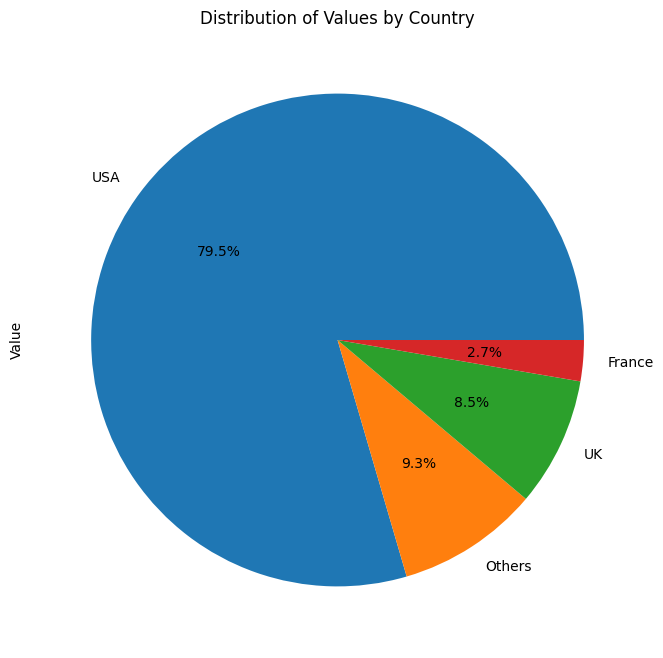

In [ ]:
#visualising all the missing values
#sns.heatmap(data.isnull(), cbar=False)
data.count()
#removing all null values
data = data.dropna()

#again visualizing null values using another library
##msno.matrix(data)
percentage = data['color'].value_counts(normalize=True) * 100
print(percentage)

# dropping colors column because aroung 96% movies are colored so there is no use of colors column
data=data.drop(['color'], axis=1)
# dropping movies link coloumn because it is of no use in prediction
data=data.drop(['movie_imdb_link'], axis=1)

percentage = data['language'].value_counts(normalize=True) * 100
print(percentage)#Since almost 94% of the movies were in english so there was no point of using language column in prediction
data=data.drop(['language'], axis=1)

# After checking the stats of country we decided to categorise contries into four parts ('USA', 'UK','France','Others')
#here we combined sparse classes
print(data['country'].value_counts())
data['country'] = data['country'].apply(lambda x: 'Others' if x not in ['USA', 'UK','France'] else x)
print(data['country'].value_counts())

import matplotlib.pyplot as plt

# Create a DataFrame
piedata = {'Country': ['USA', 'Others', 'UK', 'France'],
        'Value': [2987, 350, 318, 101]}
df = pd.DataFrame(piedata)
# Plot a pie chart
ax = df.plot.pie(y='Value', labels=df['Country'], autopct='%1.1f%%', figsize=(8, 8), legend=False)
# Set the title
plt.title('Distribution of Values by Country')
# Show the pie chart
#plt.show()

# after applying the code of tokenizing and stemming we got around 6000 unique keywords so it would be difficult to handle it so we will think of dropping the keyword column
data=data.drop(['plot_keywords'], axis=1)

len(data.columns)

# also know as feature processing
# Convert categorical variables to numerical using Label Encoding
label_encoder = LabelEncoder()
categorical_columns = [ 'director_name', 'actor_1_name', 'content_rating','country']

for column in categorical_columns:
    data[column] = label_encoder.fit_transform(data[column])

# Calculate the correlation matrix
correlation_matrix = data.corr()

# Create a heatmap using Seaborn
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, linewidths=1,cmap="YlOrRd", fmt=".2f", square=True)
plt.title('Correlation Heatmap')
#plt.show()

#seeing the corelation map we are dropping the below column
data=data.drop(['movie_facebook_likes'], axis=1)
data=data.drop(['num_voted_users'], axis=1)
data=data.drop(['num_user_for_reviews'], axis=1)
data=data.drop(['actor_2_facebook_likes'], axis=1)
data=data.drop(['num_critic_for_reviews'], axis=1)

# Calculate the correlation matrix
correlation_matrix = data.corr()
# Create a heatmap using Seaborn
plt.figure(figsize=(15, 8))
sns.heatmap(correlation_matrix, annot=True, linewidths=1,cmap="YlOrRd", fmt=".2f", square=True)
plt.title('Correlation Heatmap')
plt.show()

# first #creating the target column that predicts the success of movie
#though here we used gross and budget but we can also use imdb rating prdiction and then predict whether it was hit or flop (like 1-2.5)
# or we can
#feature interaction for feature generation
# Create the 'Gross_Budget_Percentage' column
data['Gross_Budget_Percentage'] = ((data['gross'] - data['budget']) / data['budget']) * 100
weight=20
# Include 'imdb_score' as a factor
data['Target'] = data['Gross_Budget_Percentage'] + (data['imdb_score'] * weight)  # Adjust the weight factor

data['Target'].describe()

#  creating a 'Target_Class' column:
# first 0,10,20
# then 50, 500, 1000
#then 50,250,500
#using binning for feature generation so first movie is checked if it falls left of 100 or right of it and so on the tree continues this is called binning using decision tree split
bins = [-float('inf'), 70, 120, 260, float('inf')]  # Adjust the bin boundaries as needed
labels = [1,2,3,4]# here 4 represents super hit, then 3 represents blockbuster and then average and flop
data['Target_Class'] = pd.cut(data['Target'], bins=bins, labels=labels, right=False)
# Drop the intermediate columns if you only want the final 'Target' or 'Target_Class'
data = data.drop(['Gross_Budget_Percentage'], axis=1)
# Display the updated dataset
print(data[['movie_title','Target_Class','Target']] )

data['Target_Class'].value_counts()

#feature preprocessing
# Split the 'genres' column into separate genres
genres_split = data['genres'].str.split('|', expand=True)
# Perform one-hot encoding on the genres
genres_encoded = pd.get_dummies(genres_split, prefix='genre', prefix_sep='_')
# Concatenate the encoded genres with the original dataset
data = pd.concat([data, genres_encoded], axis=1)
# Drop the original 'genres' column and the temporary split columns
data = data.drop(['genres'], axis=1)

if data.columns.duplicated().any():
    print(f"Duplicate column names found: {data.columns[data.columns.duplicated()]}")
    df_grouped = data.groupby(level=0, axis=1).sum()  # You can use 'join' instead of 'sum' if the data type is string
    data = df_grouped
    print(f"Duplicate column names found: {data.columns[data.columns.duplicated()]}")
    print("Duplicate columns merged.")
else:
    print("No duplicate column names.")

we need know if the occurrence of missing values are sparsely located or located as a big chunk. This heatmap visualization immediately tells us such tendency. Also, if more than 2 columns have correlation in missing value locations, such correlation will be visualized. (Again, not the case for this dataset, but it is important to know the fact that there is no such correlation in this dataset.)

In [ ]:
data.columns

Index(['director_name', 'num_critic_for_reviews', 'duration',
       'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name',
       'actor_1_facebook_likes', 'gross', 'genres', 'actor_1_name',
       'movie_title', 'num_voted_users', 'cast_total_facebook_likes',
       'actor_3_name', 'facenumber_in_poster', 'num_user_for_reviews',
       'country', 'content_rating', 'budget', 'title_year',
       'actor_2_facebook_likes', 'imdb_score', 'aspect_ratio',
       'movie_facebook_likes'],
      dtype='object')

In [ ]:
data['title_year'].value_counts()

DATA PROCESSING


DIVIDING THE DATASET INTO TEST, TRAIN AND VALIDATE

In [ ]:
pip install pycaret

In [ ]:
from mlxtend.classifier import StackingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_score


In [ ]:
#splitting of data into train,test
train, test = train_test_split(data, test_size=0.2, random_state=42, shuffle=True)

len(test)

# obtaining the train columns of the data means creating a new data after removing the target variable column
traindata=train.drop(['Target','Target_Class'],axis=1)
non_numeral_columns = traindata.select_dtypes(exclude=[np.number])
# Drop the non-numeral columns from the DataFrame
traindata = traindata.drop(non_numeral_columns.columns, axis=1)
testdata=test.drop(['Target','Target_Class'],axis=1)
non_numeral_columns = testdata.select_dtypes(exclude=[np.number])
# Drop the non-numeral columns from the DataFrame
testdata = testdata.drop(non_numeral_columns.columns, axis=1)

if data.columns.duplicated().any():
    print(f"Duplicate column names found: {data.columns[data.columns.duplicated()]}")

# #using pycaret
# from pycaret.classification import *
# grid = setup(data, target='Target_Class')
# # evaluate models and compare models
# best = compare_models()
# # report the best model
# print(best)

MODEL - LOGISTIC REGRESSION


In [ ]:
logr = linear_model.LogisticRegression()
logr.fit(traindata,train['Target_Class'])
predlogr = logr.predict(testdata)
print(accuracy_score(test['Target_Class'], predlogr))
print(confusion_matrix(test['Target_Class'], predlogr))
print(classification_report(test['Target_Class'], predlogr))

0.8457446808510638
[[160  22   1   0]
 [ 42  93  18   0]
 [  0  15 220  12]
 [  0   0   6 163]]
              precision    recall  f1-score   support

           1       0.79      0.87      0.83       183
           2       0.72      0.61      0.66       153
           3       0.90      0.89      0.89       247
           4       0.93      0.96      0.95       169

    accuracy                           0.85       752
   macro avg       0.83      0.83      0.83       752
weighted avg       0.84      0.85      0.84       752



MODEL - KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
# tried different values of n_neighbours in order to increase accuracy
knn = KNeighborsClassifier(n_neighbors=20,weights='distance')
knn.fit(traindata,train['Target_Class'])
predknn = knn.predict(testdata)
print(accuracy_score(test['Target_Class'], predknn))
print(confusion_matrix(test['Target_Class'], predknn))
print(classification_report(test['Target_Class'], predknn))

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7b4fe76343a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 847, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 984, in _make_controller_from_path
    lib_controller = controller_class(filepath=filepath, prefix=prefix)
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 111, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
  File "/usr/lib/python3.10/ctypes/__init__.py", line 374, in __init__
    self._handle = _dlopen(self._name, mode)
OSError: /usr/local/lib/python3.10/dist-packages/scipy.libs/libopenblasp-r0-23e5df77.3.21.dev.so: cannot open shared object file: No such file or directory


0.8643617021276596
[[159  23   1   0]
 [ 28 103  22   0]
 [  1  17 224   5]
 [  0   0   5 164]]
              precision    recall  f1-score   support

           1       0.85      0.87      0.86       183
           2       0.72      0.67      0.70       153
           3       0.89      0.91      0.90       247
           4       0.97      0.97      0.97       169

    accuracy                           0.86       752
   macro avg       0.86      0.85      0.86       752
weighted avg       0.86      0.86      0.86       752



MODEL - ADABOOST

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(n_estimators=100)
ada.fit(traindata,train['Target_Class'])
predada = ada.predict(testdata)
print(accuracy_score(test['Target_Class'], predada))
print(confusion_matrix(test['Target_Class'], predada))
print(classification_report(test['Target_Class'], predada))

0.7579787234042553
[[121  62   0   0]
 [  1 124  28   0]
 [  0   5 242   0]
 [  0   0  86  83]]
              precision    recall  f1-score   support

           1       0.99      0.66      0.79       183
           2       0.65      0.81      0.72       153
           3       0.68      0.98      0.80       247
           4       1.00      0.49      0.66       169

    accuracy                           0.76       752
   macro avg       0.83      0.74      0.74       752
weighted avg       0.82      0.76      0.75       752



MODEL - SVM

In [ ]:
# from sklearn.svm import SVC
# svc = SVC()
# svc.fit(traindata, train['Target_Class'])
# pred = svc.predict(testdata)
# print(accuracy_score(test['Target_Class'], pred))
# print(confusion_matrix(test['Target_Class'], pred))
# print(classification_report(test['Target_Class'], pred))

0.7539893617021277
[[170  12   1   0]
 [ 71  61  21   0]
 [ 31   5 209   2]
 [ 23   0  19 127]]
              precision    recall  f1-score   support

           1       0.58      0.93      0.71       183
           2       0.78      0.40      0.53       153
           3       0.84      0.85      0.84       247
           4       0.98      0.75      0.85       169

    accuracy                           0.75       752
   macro avg       0.79      0.73      0.73       752
weighted avg       0.80      0.75      0.75       752



MODEL - GRADIENT BOOSTING

In [ ]:
clf = HistGradientBoostingClassifier(max_iter=1).fit(traindata,train['Target_Class'])
predclf = clf.predict(testdata)
print(accuracy_score(test['Target_Class'], predclf))
print(confusion_matrix(test['Target_Class'], predclf))
print(classification_report(test['Target_Class'], predclf))

0.7313829787234043
[[153   2  28   0]
 [ 14  30 109   0]
 [  0   2 242   3]
 [  1   0  43 125]]
              precision    recall  f1-score   support

           1       0.91      0.84      0.87       183
           2       0.88      0.20      0.32       153
           3       0.57      0.98      0.72       247
           4       0.98      0.74      0.84       169

    accuracy                           0.73       752
   macro avg       0.84      0.69      0.69       752
weighted avg       0.81      0.73      0.70       752



MODEL - RANDOM FOREST

In [ ]:

# Create and train the Random Forest model
# tried different values of random_state in order to increase accuracy
rf_classifier = RandomForestClassifier(max_depth=None, min_samples_split=2, random_state=75)
rf_classifier.fit(traindata,train['Target_Class'])
pred_rf = rf_classifier.predict(testdata)
# Evaluate the performance of the Random Forest model
print(accuracy_score(test['Target_Class'], pred_rf))
print(confusion_matrix(test['Target_Class'], pred_rf))
print(classification_report(test['Target_Class'], pred_rf))

0.773936170212766
[[164  16   3   0]
 [ 35  70  48   0]
 [  7   6 221  13]
 [  1   1  40 127]]
              precision    recall  f1-score   support

           1       0.79      0.90      0.84       183
           2       0.75      0.46      0.57       153
           3       0.71      0.89      0.79       247
           4       0.91      0.75      0.82       169

    accuracy                           0.77       752
   macro avg       0.79      0.75      0.76       752
weighted avg       0.78      0.77      0.76       752



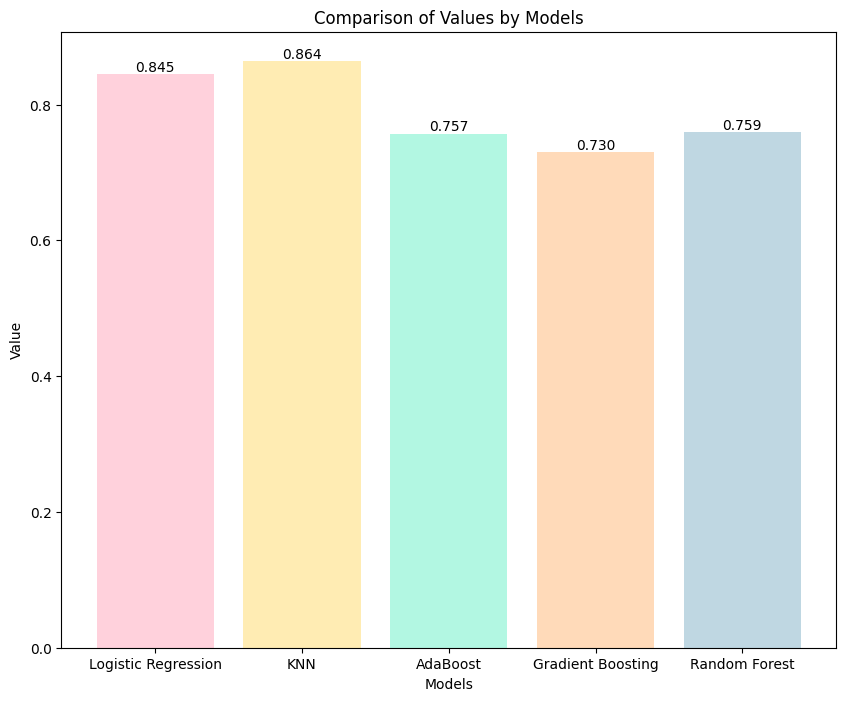

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a DataFrame with the given data
data = {'Model': ['Logistic Regression', 'KNN', 'AdaBoost', 'Gradient Boosting', 'Random Forest'],
        'Value': [0.845, 0.864, 0.757, 0.730, 0.759]}

df = pd.DataFrame(data)

# Create a bar graph
plt.figure(figsize=(10,8))
bars = plt.bar(df['Model'], df['Value'], color=['#FFD1DC', '#FFECB3', '#B2F7E2', '#FFDAB9','#BFD7E2', '#FFBAB9' ])

# Add data labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.3f}', ha='center', va='bottom')

# Add labels and title
plt.xlabel('Models')
plt.ylabel('Value')
plt.title('Comparison of Values by Models')

# Show the plot
plt.show()


STACKING USING PYTHON LIBRARY
repetition of stacking from 1 to 10 and find the mean of accuracy and precision

In [ ]:
metaknn = KNeighborsClassifier(n_neighbors=50,weights='distance')
clf_stack = StackingClassifier(classifiers =[logr,rf_classifier,clf,ada,knn], meta_classifier = metaknn, use_probas = True, use_features_in_secondary = True)

model_stack = clf_stack.fit(traindata, train['Target_Class'])   # training of stacked model
pred_stack = model_stack.predict(testdata)

acc_stack = accuracy_score(test['Target_Class'], pred_stack)  # evaluating accuracy
print(acc_stack)

0.875


In [ ]:
metaknn = KNeighborsClassifier(n_neighbors=50, weights='distance')
clf_stack = StackingClassifier(
    classifiers=[logr, rf_classifier, clf, ada, knn],
    meta_classifier=metaknn,
    use_probas=True,
    use_features_in_secondary=True
)

# Train the model
model_stack = clf_stack.fit(traindata, train['Target_Class'])
# Make predictions on the test set
pred_stack = model_stack.predict(testdata)
# Evaluate accuracy
acc_stack = accuracy_score(test['Target_Class'], pred_stack)
print(f"Accuracy {acc_stack:.3f}")

Training epoch 1/10
Accuracy after epoch 1: 0.875
Training epoch 2/10
Accuracy after epoch 2: 0.875
Training epoch 3/10
Accuracy after epoch 3: 0.875
Training epoch 4/10
Accuracy after epoch 4: 0.875
Training epoch 5/10
Accuracy after epoch 5: 0.875
Training epoch 6/10
Accuracy after epoch 6: 0.875
Training epoch 7/10
Accuracy after epoch 7: 0.875
Training epoch 8/10
Accuracy after epoch 8: 0.875
Training epoch 9/10
Accuracy after epoch 9: 0.875
Training epoch 10/10
Accuracy after epoch 10: 0.875
Final Accuracy after 10 epochs: 0.875


In [ ]:
metaknn = KNeighborsClassifier(n_neighbors=50,weights='distance')
clf_stack = StackingClassifier(classifiers =[logr, rf_classifier], meta_classifier = metaknn, use_probas = True, use_features_in_secondary = True)

model_stack = clf_stack.fit(traindata, train['Target_Class'])   # training of stacked model
pred_stack = model_stack.predict(testdata)

acc_stack = accuracy_score(test['Target_Class'], pred_stack)  # evaluating accuracy
print(acc_stack)

0.875


In [ ]:
metaknn = KNeighborsClassifier(n_neighbors=50,weights='distance')
clf_stack = StackingClassifier(classifiers =[rf_classifier, ada], meta_classifier = metaknn, use_probas = True, use_features_in_secondary = True)

model_stack = clf_stack.fit(traindata, train['Target_Class'])   # training of stacked model
pred_stack = model_stack.predict(testdata)

acc_stack = accuracy_score(test['Target_Class'], pred_stack)  # evaluating accuracy
print(acc_stack)

0.875


In [ ]:
metaknn = KNeighborsClassifier(n_neighbors=50,weights='distance')
clf_stack = StackingClassifier(classifiers =[rf_classifier, knn], meta_classifier = metaknn, use_probas = True, use_features_in_secondary = True)

model_stack = clf_stack.fit(traindata, train['Target_Class'])   # training of stacked model
pred_stack = model_stack.predict(testdata)

acc_stack = accuracy_score(test['Target_Class'], pred_stack)  # evaluating accuracy
print(acc_stack)

0.875


In [ ]:
metaknn = KNeighborsClassifier(n_neighbors=50,weights='distance')
clf_stack = StackingClassifier(classifiers =[logr,ada], meta_classifier = metaknn, use_probas = True, use_features_in_secondary = True)

model_stack = clf_stack.fit(traindata, train['Target_Class'])   # training of stacked model
pred_stack = model_stack.predict(testdata)

acc_stack = accuracy_score(test['Target_Class'], pred_stack)  # evaluating accuracy
print(acc_stack)

0.875


In [ ]:
metaknn = KNeighborsClassifier(n_neighbors=50,weights='distance')
clf_stack = StackingClassifier(classifiers =[logr, knn], meta_classifier = metaknn, use_probas = True, use_features_in_secondary = True)

model_stack = clf_stack.fit(traindata, train['Target_Class'])   # training of stacked model
pred_stack = model_stack.predict(testdata)

acc_stack = accuracy_score(test['Target_Class'], pred_stack)  # evaluating accuracy
print(acc_stack)

0.8736702127659575


In [ ]:
metaknn = KNeighborsClassifier(n_neighbors=50,weights='distance')
clf_stack = StackingClassifier(classifiers =[ada, knn], meta_classifier = metaknn, use_probas = True, use_features_in_secondary = True)

model_stack = clf_stack.fit(traindata, train['Target_Class'])   # training of stacked model
pred_stack = model_stack.predict(testdata)

acc_stack = accuracy_score(test['Target_Class'], pred_stack)  # evaluating accuracy
print(acc_stack)

0.8736702127659575


In [ ]:
metaknn = KNeighborsClassifier(n_neighbors=50,weights='distance')
clf_stack = StackingClassifier(classifiers =[logr, rf_classifier, ada], meta_classifier = metaknn, use_probas = True, use_features_in_secondary = True)

model_stack = clf_stack.fit(traindata, train['Target_Class'])   # training of stacked model
pred_stack = model_stack.predict(testdata)

acc_stack = accuracy_score(test['Target_Class'], pred_stack)  # evaluating accuracy
print(acc_stack)

0.8550531914893617


In [ ]:
metaknn = KNeighborsClassifier(n_neighbors=50,weights='distance')
clf_stack = StackingClassifier(classifiers =[logr, rf_classifier, knn], meta_classifier = metaknn, use_probas = True, use_features_in_secondary = True)

model_stack = clf_stack.fit(traindata, train['Target_Class'])   # training of stacked model
pred_stack = model_stack.predict(testdata)

acc_stack = accuracy_score(test['Target_Class'], pred_stack)  # evaluating accuracy
print(acc_stack)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8736702127659575


In [ ]:
metaknn = KNeighborsClassifier(n_neighbors=50,weights='distance')
clf_stack = StackingClassifier(classifiers =[logr, ada, knn], meta_classifier = metaknn, use_probas = True, use_features_in_secondary = True)

model_stack = clf_stack.fit(traindata, train['Target_Class'])   # training of stacked model
pred_stack = model_stack.predict(testdata)

acc_stack = accuracy_score(test['Target_Class'], pred_stack)  # evaluating accuracy
print(acc_stack)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8736702127659575


In [ ]:
metaknn = KNeighborsClassifier(n_neighbors=50,weights='distance')
clf_stack = StackingClassifier(classifiers =[ rf_classifier, ada, knn], meta_classifier = metaknn, use_probas = True, use_features_in_secondary = True)

model_stack = clf_stack.fit(traindata, train['Target_Class'])   # training of stacked model
pred_stack = model_stack.predict(testdata)

acc_stack = accuracy_score(test['Target_Class'], pred_stack)  # evaluating accuracy
print(acc_stack)

0.8736702127659575


In [ ]:
metaknn = KNeighborsClassifier(n_neighbors=50,weights='distance')
clf_stack = StackingClassifier(classifiers =[logr, rf_classifier, ada, knn], meta_classifier = metaknn, use_probas = True, use_features_in_secondary = True)

model_stack = clf_stack.fit(traindata, train['Target_Class'])   # training of stacked model
pred_stack = model_stack.predict(testdata)

acc_stack = accuracy_score(test['Target_Class'], pred_stack)  # evaluating accuracy
print(acc_stack)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8736702127659575
